# DQN Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a Deep Q-Network (DQN) agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 DQN hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive


## 1. Setup: Mount Google Drive & Install Dependencies


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/dqn', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/dqn', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [5]:
# Install required packages (order matters for numpy compatibility!)
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


In [6]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [7]:
class ClinicEnv(gym.Env):
    """
    Dermatology Clinic Triage Environment.

    Observation Space (15 dimensions):
        [0] age_norm, [1] duration_norm, [2] fever_flag, [3] infection_flag,
        [4-11] symptom_embed (8-dim), [12] room_avail, [13] queue_len_norm, [14] time_norm

    Action Space (8 discrete actions):
        0: send_doctor, 1: send_nurse, 2: remote_advice, 3: escalate_priority,
        4: defer_patient, 5: idle, 6: open_room, 7: close_room
    """

    metadata = {"render_modes": ["human", "rgb_array", "ansi"], "render_fps": 6}

    SEVERITY_MILD = 0
    SEVERITY_MODERATE = 1
    SEVERITY_SEVERE = 2
    SEVERITY_CRITICAL = 3

    def __init__(self, seed: Optional[int] = None, max_steps: int = 500, render_mode: Optional[str] = None):
        super().__init__()
        self.max_steps = max_steps
        self.render_mode = render_mode

        # Spaces
        obs_low = np.array([0.0] * 15, dtype=np.float32)
        obs_high = np.array([1.0] * 15, dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # State
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0

        # Stats
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        if seed is not None:
            self.seed(seed)
        self.reset()

    def seed(self, seed: Optional[int] = None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = np.random.choice([0, 1, 2, 3], p=[0.4, 0.35, 0.2, 0.05])
        age_norm = np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0)
        duration_norm = np.clip(np.random.exponential(0.5), 0.0, 1.0)
        fever_flag = 1.0 if np.random.rand() < (0.05 + 0.2 * severity) else 0.0
        infection_flag = 1.0 if np.random.rand() < (0.05 + 0.25 * severity) else 0.0
        base = 0.2 + 0.25 * severity
        symptom_embed = np.clip(np.random.normal(loc=base, scale=0.08, size=(8,)), 0.0, 1.0)
        return {
            "severity": int(severity), "age_norm": float(age_norm),
            "duration_norm": float(duration_norm), "fever_flag": float(fever_flag),
            "infection_flag": float(infection_flag), "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str, Any]) -> np.ndarray:
        vec = [patient["age_norm"], patient["duration_norm"],
               patient["fever_flag"], patient["infection_flag"]]
        vec += list(patient["symptom_embed"])
        vec += [1.0 if self.num_open_rooms > 0 else 0.0,
                np.clip(len(self.queue) / 10.0, 0.0, 1.0),
                np.clip(self.step_count / self.max_steps, 0.0, 1.0)]
        return np.array(vec, dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self.episode_stats = {
            "correct_triages": 0, "incorrect_triages": 0,
            "total_patients": 0, "total_wait_time": 0.0, "total_reward": 0.0
        }

        self._maybe_spawn_next()
        obs = self._form_observation(self.current_patient)
        info = self._get_info()
        return obs, info

    def _maybe_spawn_next(self):
        if self.current_patient is None and len(self.queue) > 0:
            self.current_patient = self.queue.pop(0)
        elif self.current_patient is None:
            self.current_patient = self._sample_patient()

    def _get_correct_action(self, severity: int) -> int:
        if severity == 0: return 2      # mild -> remote
        elif severity == 1: return 1    # moderate -> nurse
        elif severity == 2: return 0    # severe -> doctor
        else: return 3                  # critical -> escalate

    def _get_info(self) -> Dict[str, Any]:
        if self.current_patient is None:
            return {"queue_length": len(self.queue)}
        return {
            "current_severity": int(self.current_patient["severity"]),
            "correct_action": int(self._get_correct_action(self.current_patient["severity"])),
            "num_open_rooms": int(self.num_open_rooms),
            "queue_length": len(self.queue),
            "episode_stats": self.episode_stats.copy()
        }

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert self.action_space.contains(action), f"Invalid action: {action}"

        self.step_count += 1
        patient = self.current_patient
        reward = 0.0

        correct_action = self._get_correct_action(patient["severity"])

        if action == correct_action:
            if patient["severity"] == 0:
                reward += 1.0
            elif patient["severity"] == 1:
                reward += 1.0
            elif patient["severity"] == 2:
                reward += 2.0
            else:
                reward += 3.0 if patient["wait_time"] < 5.0 else 2.0
            self.episode_stats["correct_triages"] += 1
        else:
            reward -= 1.5
            self.episode_stats["incorrect_triages"] += 1

        if action == 6:
            self.num_open_rooms += 1
        elif action == 7 and self.num_open_rooms > 0:
            self.num_open_rooms -= 1
        elif action == 4:
            patient["wait_time"] += 1.0
            self.queue.append(patient)
            self.current_patient = None
        else:
            self.current_patient = None

        wait_increment = 0.01 * len(self.queue)
        for p in self.queue:
            p["wait_time"] += 1.0
        self.total_wait += wait_increment
        reward -= 0.01 * wait_increment
        reward -= 0.05 * self.num_open_rooms

        self._maybe_spawn_next()
        self.episode_stats["total_patients"] += 1
        self.episode_stats["total_wait_time"] += wait_increment
        self.episode_stats["total_reward"] += reward

        obs = self._form_observation(self.current_patient)
        terminated = False
        truncated = self.step_count >= self.max_steps
        info = self._get_info()

        return obs, float(reward), terminated, truncated, info

    def render(self):
        pass

    def close(self):
        pass

print("✓ ClinicEnv defined successfully!")


✓ ClinicEnv defined successfully!


## 3. Load DQN Configurations (10 Hyperparameter Sets)


In [8]:
# Embedded DQN configurations (AGGRESSIVE)
DQN_CONFIGS = {
  "configs": [
    {
      "id": "dqn_aggressive_v1",
      "description": "High learning rate with fast exploration",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.6,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.02,
      "target_update_interval": 500,
      "learning_starts": 500,
      "train_freq": 2,
      "gradient_steps": 2
    },
    {
      "id": "dqn_aggressive_v2",
      "description": "Very high learning rate with aggressive updates",
      "learning_rate": 0.002,
      "gamma": 0.98,
      "buffer_size": 30000,
      "batch_size": 32,
      "exploration_fraction": 0.7,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.01,
      "target_update_interval": 250,
      "learning_starts": 250,
      "train_freq": 1,
      "gradient_steps": 3
    },
    {
      "id": "dqn_balanced_aggressive",
      "description": "Balanced but still aggressive approach",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.6,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.05,
      "target_update_interval": 750,
      "learning_starts": 500,
      "train_freq": 2,
      "gradient_steps": 1
    },
    {
      "id": "dqn_extended_explore",
      "description": "Extended exploration phase (80%)",
      "learning_rate": 0.0005,
      "gamma": 0.99,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.8,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.05,
      "target_update_interval": 1000,
      "learning_starts": 1000,
      "train_freq": 4,
      "gradient_steps": 1
    },
    {
      "id": "dqn_large_batch_aggressive",
      "description": "Large batch with aggressive learning",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "buffer_size": 100000,
      "batch_size": 128,
      "exploration_fraction": 0.5,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.03,
      "target_update_interval": 500,
      "learning_starts": 1000,
      "train_freq": 4,
      "gradient_steps": 2
    },
    {
      "id": "dqn_fast_convergence",
      "description": "Fast convergence with frequent updates",
      "learning_rate": 0.0015,
      "gamma": 0.99,
      "buffer_size": 40000,
      "batch_size": 64,
      "exploration_fraction": 0.5,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.02,
      "target_update_interval": 200,
      "learning_starts": 200,
      "train_freq": 1,
      "gradient_steps": 4
    },
    {
      "id": "dqn_high_gamma_explore",
      "description": "High gamma with extended exploration",
      "learning_rate": 0.0005,
      "gamma": 0.995,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.7,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.1,
      "target_update_interval": 1000,
      "learning_starts": 1000,
      "train_freq": 4,
      "gradient_steps": 1
    },
    {
      "id": "dqn_multi_step_aggressive",
      "description": "Multiple gradient steps with high LR",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.6,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.05,
      "target_update_interval": 500,
      "learning_starts": 500,
      "train_freq": 2,
      "gradient_steps": 3
    },
    {
      "id": "dqn_very_aggressive",
      "description": "Maximum aggression - high LR, fast updates",
      "learning_rate": 0.003,
      "gamma": 0.98,
      "buffer_size": 20000,
      "batch_size": 32,
      "exploration_fraction": 0.5,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.01,
      "target_update_interval": 100,
      "learning_starts": 100,
      "train_freq": 1,
      "gradient_steps": 4
    },
    {
      "id": "dqn_long_explore_medium_lr",
      "description": "Long exploration (90%) with medium learning rate",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "buffer_size": 50000,
      "batch_size": 64,
      "exploration_fraction": 0.9,
      "exploration_initial_eps": 1.0,
      "exploration_final_eps": 0.1,
      "target_update_interval": 1000,
      "learning_starts": 500,
      "train_freq": 4,
      "gradient_steps": 2
    }
  ]
}

configs = DQN_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} DQN configurations (AGGRESSIVE SET)")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")

✓ Loaded 10 DQN configurations
  - dqn_baseline: Baseline DQN configuration
  - dqn_high_lr: Higher learning rate for faster adaptation
  - dqn_large_buffer: Larger replay buffer for better experience diversity
  - dqn_large_batch: Larger batch size for stable gradients
  - dqn_fast_target_update: More frequent target network updates
  - dqn_slow_exploration: Slower epsilon decay for longer exploration
  - dqn_high_gamma: Higher discount factor for long-term planning
  - dqn_multi_step: Multiple gradient steps per update
  - dqn_aggressive: Aggressive learning with high LR and frequent updates
  - dqn_conservative: Conservative learning with low LR and large buffer


In [9]:
def evaluate_agent(model, env, num_episodes=20, deterministic=True):
    """Evaluate trained agent and return metrics."""
    episode_rewards = []
    episode_lengths = []
    triage_accuracies = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0.0
        episode_length = 0
        correct = 0
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

            if 'correct_action' in info:
                total += 1
                if action == info['correct_action']:
                    correct += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        if total > 0:
            triage_accuracies.append(100.0 * correct / total)

    return {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "mean_triage_accuracy": np.mean(triage_accuracies) if triage_accuracies else 0.0,
        "std_triage_accuracy": np.std(triage_accuracies) if triage_accuracies else 0.0
    }

def train_dqn_config(config, env, total_timesteps=50000, seed=42, verbose=False):
    """Train DQN with given configuration."""
    env.reset(seed=seed)

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        buffer_size=config["buffer_size"],
        batch_size=config["batch_size"],
        exploration_fraction=config["exploration_fraction"],
        exploration_initial_eps=config["exploration_initial_eps"],
        exploration_final_eps=config["exploration_final_eps"],
        target_update_interval=config["target_update_interval"],
        learning_starts=config["learning_starts"],
        train_freq=config["train_freq"],
        gradient_steps=config["gradient_steps"],
        seed=seed,
        verbose=0
    )

    model.learn(total_timesteps=total_timesteps)

    # Evaluate
    eval_results = evaluate_agent(model, env, num_episodes=20)

    return model, eval_results

def save_results_to_csv(results, filename):
    """Save training results to CSV."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")

def plot_config_comparison(results_df, save_path=None):
    """Plot comparison of all configurations."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean reward comparison
    ax1 = axes[0]
    sorted_df = results_df.sort_values('mean_reward', ascending=False)
    bars = ax1.barh(sorted_df['config_id'], sorted_df['mean_reward'],
                    color='steelblue', alpha=0.8)
    ax1.set_xlabel('Mean Reward', fontsize=12)
    ax1.set_title('Configuration Performance Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Triage accuracy comparison
    ax2 = axes[1]
    bars = ax2.barh(sorted_df['config_id'], sorted_df['triage_accuracy'],
                    color='coral', alpha=0.8)
    ax2.set_xlabel('Triage Accuracy (%)', fontsize=12)
    ax2.set_title('Triage Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")

    plt.show()

print("✓ Helper functions defined!")


✓ Helper functions defined!


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [11]:
# Quick sweep training
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=42, max_steps=500)

    start_time = time.time()

    # Train
    try:
        model, eval_results = train_dqn_config(
            config, env,
            total_timesteps=100000,
            seed=42
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "buffer_size": config["buffer_size"],
            "batch_size": config["batch_size"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/dqn/{config['id']}_sweep.zip"
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)


QUICK SWEEP: Training all 10 configurations

[1/10] Training: dqn_baseline
Description: Baseline DQN configuration
------------------------------------------------------------
✓ Completed in 140.3s
  Mean Reward: 622.56 ± 9.68
  Triage Accuracy: 31.6%
  Model saved: /content/drive/MyDrive/RL_Summative/models/dqn/dqn_baseline_sweep.zip

[2/10] Training: dqn_high_lr
Description: Higher learning rate for faster adaptation
------------------------------------------------------------
✓ Completed in 133.6s
  Mean Reward: 645.04 ± 13.27
  Triage Accuracy: 33.2%
  Model saved: /content/drive/MyDrive/RL_Summative/models/dqn/dqn_high_lr_sweep.zip

[3/10] Training: dqn_large_buffer
Description: Larger replay buffer for better experience diversity
------------------------------------------------------------
✓ Completed in 131.6s
  Mean Reward: 623.30 ± 11.00
  Triage Accuracy: 31.8%
  Model saved: /content/drive/MyDrive/RL_Summative/models/dqn/dqn_large_buffer_sweep.zip

[4/10] Training: dqn_large

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/dqn_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
             config_id  mean_reward  triage_accuracy  training_time_sec
dqn_fast_target_update   649.899540            32.31         132.653600
        dqn_multi_step   645.227030            32.30         194.614815
           dqn_high_lr   645.037025            33.18         133.621361
        dqn_high_gamma   644.937025            33.17         129.740256
        dqn_aggressive   643.607200            33.71         316.844359
  dqn_slow_exploration   624.324700            32.22         124.323675
       dqn_large_batch   624.099700            32.82         131.578017
      dqn_large_buffer   623.299700            31.76         131.638927
          dqn_baseline   622.559700            31.65         140.250411
      dqn_conservative   506.599700            33.88          91.179960
✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/dqn_sweep_comparison.png


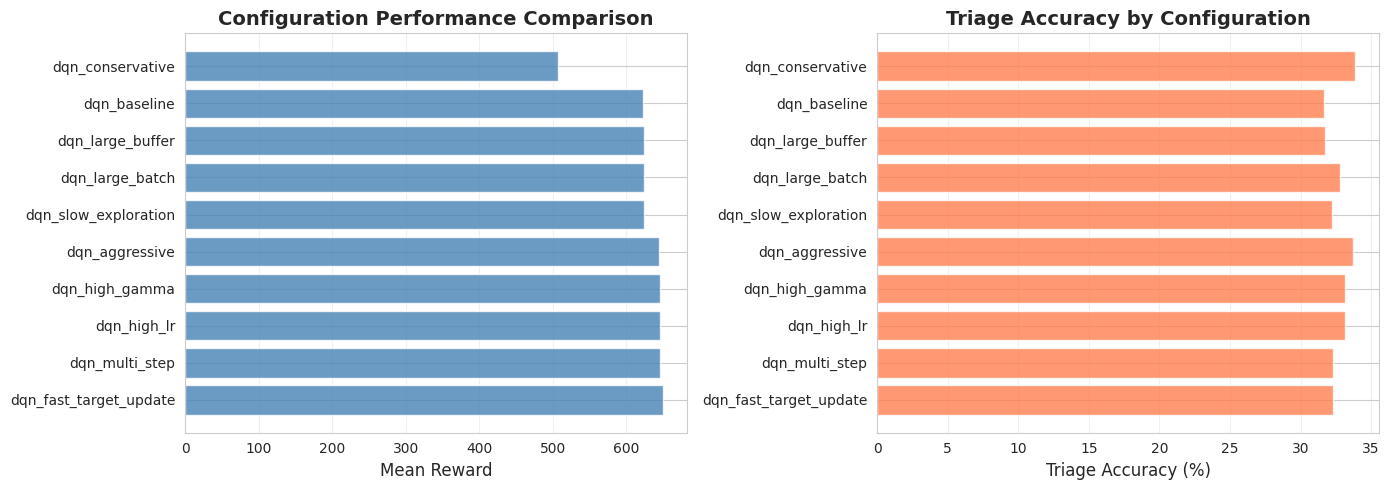


🏆 BEST CONFIGURATION: dqn_fast_target_update
   Mean Reward: 649.90
   Triage Accuracy: 32.3%

   Hyperparameters:
     learning_rate: 0.0003
     gamma: 0.99
     buffer_size: 50000
     batch_size: 64


In [12]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/dqn_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/dqn_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'buffer_size', 'batch_size']:
    print(f"     {key}: {best_config[key]}")
